In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [2]:
data = pd.read_csv('Downloads/RELIANCE.NS.csv')

data = data[['Date', 'Close']]
data

,Date,Close
0,2010-01-13,539.189026
1,2010-01-14,555.583618
2,2010-01-15,550.160034
3,2010-01-18,544.587830
4,2010-01-19,537.405945
...,...,...
3459,2024-01-08,2587.350098
3460,2024-01-09,2580.500000
3461,2024-01-10,2650.100098
3462,2024-01-11,2719.800049


In [3]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-01-22,521.977173,522.076233,533.691162,537.405945,544.587830,550.160034,555.583618,539.189026
2010-01-25,516.132568,521.977173,522.076233,533.691162,537.405945,544.587830,550.160034,555.583618
2010-01-27,508.950653,516.132568,521.977173,522.076233,533.691162,537.405945,544.587830,550.160034
2010-01-28,513.705566,508.950653,516.132568,521.977173,522.076233,533.691162,537.405945,544.587830
2010-01-29,518.188110,513.705566,508.950653,516.132568,521.977173,522.076233,533.691162,537.405945
...,...,...,...,...,...,...,...,...
2024-01-08,2587.350098,2607.699951,2596.649902,2583.300049,2611.699951,2590.250000,2584.949951,2605.550049
2024-01-09,2580.500000,2587.350098,2607.699951,2596.649902,2583.300049,2611.699951,2590.250000,2584.949951
2024-01-10,2650.100098,2580.500000,2587.350098,2607.699951,2596.649902,2583.300049,2611.699951,2590.250000


In [5]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 521.977173,  522.076233,  533.691162, ...,  550.160034,
         555.583618,  539.189026],
       [ 516.132568,  521.977173,  522.076233, ...,  544.58783 ,
         550.160034,  555.583618],
       [ 508.950653,  516.132568,  521.977173, ...,  537.405945,
         544.58783 ,  550.160034],
       ...,
       [2650.100098, 2580.5     , 2587.350098, ..., 2583.300049,
        2611.699951, 2590.25    ],
       [2719.800049, 2650.100098, 2580.5     , ..., 2596.649902,
        2583.300049, 2611.699951],
       [2741.449951, 2719.800049, 2650.100098, ..., 2607.699951,
        2596.649902, 2583.300049]])

In [6]:
shifted_df_as_np.shape

(3401, 8)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.85073524, -0.85065621, -0.84139012, ..., -0.82825167,
        -0.82392487, -0.83700406],
       [-0.85539791, -0.85073524, -0.85065621, ..., -0.83269703,
        -0.82825167, -0.82392487],
       [-0.86112746, -0.85539791, -0.85073524, ..., -0.83842656,
        -0.83269703, -0.82825167],
       ...,
       [ 0.84702676,  0.79150158,  0.79696641, ...,  0.79373539,
         0.8163921 ,  0.79927988],
       [ 0.9026316 ,  0.84702676,  0.79150158, ...,  0.80438556,
         0.79373539,  0.8163921 ],
       [ 0.91990333,  0.9026316 ,  0.84702676, ...,  0.81320101,
         0.80438556,  0.79373539]])

In [8]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3401, 7), (3401,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-0.83700406, -0.82392487, -0.82825167, ..., -0.83842656,
        -0.84139012, -0.85065621],
       [-0.82392487, -0.82825167, -0.83269703, ..., -0.84139012,
        -0.85065621, -0.85073524],
       [-0.82825167, -0.83269703, -0.83842656, ..., -0.85065621,
        -0.85073524, -0.85539791],
       ...,
       [ 0.79927988,  0.8163921 ,  0.79373539, ...,  0.81320101,
         0.79696641,  0.79150158],
       [ 0.8163921 ,  0.79373539,  0.80438556, ...,  0.79696641,
         0.79150158,  0.84702676],
       [ 0.79373539,  0.80438556,  0.81320101, ...,  0.79150158,
         0.84702676,  0.9026316 ]])

In [10]:
split_index = int(len(X) * 0.90)

split_index

3060

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3060, 7), (341, 7), (3060,), (341,))

In [12]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3060, 7, 1), (341, 7, 1), (3060, 1), (341, 1))

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3060, 7, 1]),
 torch.Size([341, 7, 1]),
 torch.Size([3060, 1]),
 torch.Size([341, 1]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
train_dataset

In [16]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.700

Val Loss: 0.620
***************************************************

Epoch: 2
Batch 100, Loss: 0.100

Val Loss: 0.167
***************************************************

Epoch: 3
Batch 100, Loss: 0.016

Val Loss: 0.068
***************************************************

Epoch: 4
Batch 100, Loss: 0.008

Val Loss: 0.030
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.018
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.011
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.008
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.006
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.004
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.003
********************************

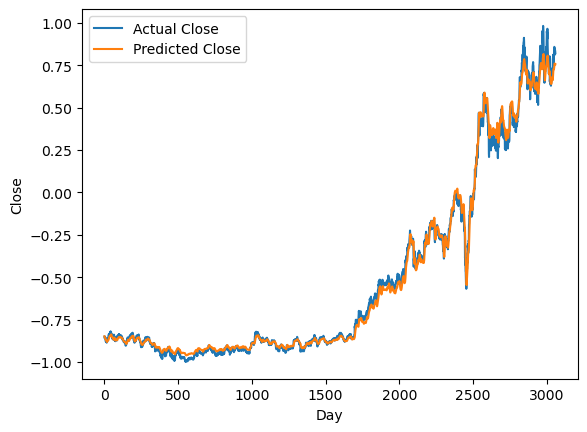

In [22]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [23]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 524.25741971,  520.87550592,  516.55354488, ..., 2535.83243869,
       2536.83203273, 2536.5293677 ])

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 521.97715883,  516.13253341,  508.95068293, ..., 2639.75002352,
       2632.05003381, 2617.99998077])

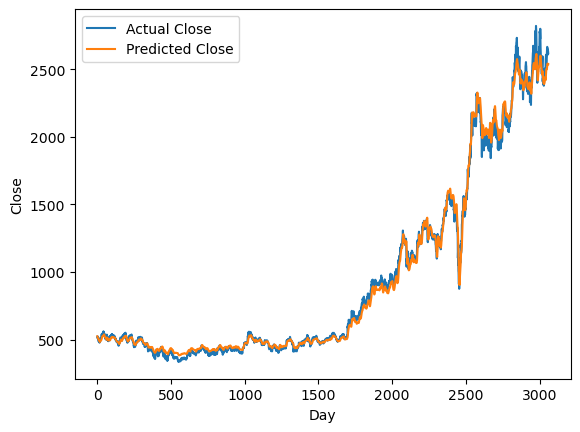

In [25]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2534.37253379, 2529.53818647, 2529.9075708 , 2522.85557265,
       2509.16362219, 2502.21741858, 2503.07206813, 2504.35198782,
       2505.74935739, 2504.96000758, 2507.45574265, 2513.52465847,
       2515.04784584, 2510.98035952, 2497.95111921, 2484.24295589,
       2473.94128713, 2467.551775  , 2461.03121511, 2449.45007494,
       2429.4520675 , 2413.03433861, 2392.09224937, 2371.77499047,
       2364.74503285, 2363.60041959, 2371.32730622, 2382.63327598,
       2393.75171446, 2398.80220839, 2392.67568834, 2385.80830764,
       2381.78923577, 2377.47728636, 2379.94194055, 2391.3151526 ,
       2409.79542677, 2427.76346409, 2437.01294038, 2442.02271537,
       2439.31001183, 2434.78475493, 2441.57607712, 2454.68877258,
       2464.2490577 , 2472.54877395, 2480.05884154, 2490.42625832,
       2501.26900339, 2508.96540685, 2510.08118063, 2515.98445627,
       2521.44961101, 2523.06790887, 2521.29495374, 2519.56966592,
       2518.33629284, 2511.56648818, 2505.26289676, 2500.51947

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([2597.64992257, 2637.94994733, 2560.39993352, 2530.4999754 ,
       2569.80003255, 2596.85011285, 2581.75003405, 2585.39987101,
       2569.30004874, 2598.05001422, 2619.74999881, 2588.35008927,
       2562.6999188 , 2499.19995803, 2502.44992749, 2502.85009385,
       2509.74997498, 2486.10011331, 2439.50000867, 2377.35012371,
       2396.24998979, 2332.44997896, 2325.30003121, 2377.74999122,
       2369.50003426, 2413.19997879, 2422.10009401, 2432.35006091,
       2405.80003913, 2357.89991682, 2375.24999747, 2382.80003687,
       2370.69993563, 2408.75003325, 2451.25000171, 2493.89992047,
       2500.600092  , 2471.60013462, 2479.85009158, 2441.55007676,
       2451.1498854 , 2526.14992203, 2549.60007409, 2529.850116  ,
       2545.64988821, 2555.1498794 , 2592.74997666, 2606.60009594,
       2603.99998589, 2572.50003476, 2631.8000419 , 2619.05008125,
       2607.3000135 , 2592.35010916, 2599.05005654, 2597.64992257,
       2550.89986762, 2565.05003695, 2557.0500719 , 2579.10008

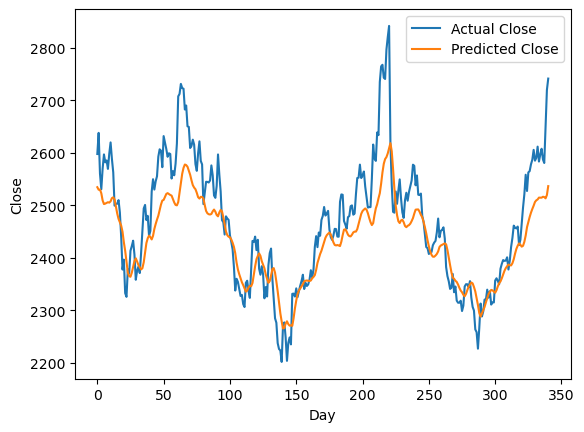

In [28]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
